# Data description

About Dataset
Introduction
This is a csv file containing 83446 records of email which are labelled as either spam or not-spam. It is formed by combining the 2007 TREC Public Spam Corpus and Enron-Spam Dataset.

**Columns**
- **label**
    - '1' indicates that the email is classified as spam.
    - '0' denotes that the email is legitimate (ham).
- **text**
    - This column contains the actual content of the email messages.

Sources
1. 2007 TREC Public Spam Corpus
- Original link: https://plg.uwaterloo.ca/~gvcormac/treccorpus07/
- Preprocessed download link: https://www.kaggle.com/datasets/bayes2003/emails-for-spam-or-ham-classification-trec-2007
2. Enron-Spam Dataset
- Original link: https://www2.aueb.gr/users/ion/data/enron-spam/
- Preprocessed download link: https://github.com/MWiechmann/enron_spam_data/


# Project objective

In this project my objective is to build the best model that is optimal for email classification for this dataset.

Step I will go through include:
 - Preprocessing data: 
     - Remove stop words, punctuation
     - Tokenizer the text data
     - Turn the tokenized data into padding sequence
 - Choose the best model and tunning parameters:
     - Go through well know model for email classification such as (Random Forest, GRU, RNN)
     - Tunning parameters to come up with the most optimal result for that model

In [569]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import text_to_word_sequence, one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Embedding, Dropout, Dense, Bidirectional, SimpleRNN, BatchNormalization, LSTM, GRU
from tensorflow.keras.models import Sequential, Model, model_from_json
import tensorflow as tf
import matplotlib.pyplot as plt

# Preprocessing steps

In [714]:
# Define function for text cleaning
def clean_text(text):
    text = ''.join([char for char in text if char not in punctuation])
    
    text = ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words and word not in ['escapenumber', 'escapelong', 'escapenumbermg', 'escapenumberd', 'aescapenumber']])
    
    return text

# Get stop_words and punctuation
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

In [715]:
# Load the data
df = pd.read_csv(r'D:\Documents\combined_data.csv')
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [716]:
# Make a dictionary of words with their respective index
index_word = {index:word for word, index in tokenizer.word_index.items()}

In [717]:
# Tokenize the data
tokenizer = Tokenizer(num_words=20000)
df['text'] = df['text'].apply(clean_text)
tokenizer.fit_on_texts(df['text'])
sequence = tokenizer.texts_to_sequences(df['text'])

In [718]:
# Padding the data
max_lenght = 500
padded = pad_sequences(sequence, maxlen=max_lenght, padding='post')
y = df['label']

In [719]:
# Let check the distribution of our class variable
y.value_counts()

1    43910
0    39538
Name: label, dtype: int64

In [720]:
# Seperate word for spam and non-spam email
sequences_class_0 = [sequence[i] for i in range(len(sequence)) if df['label'][i] == 0]
sequences_class_1 = [sequence[i] for i in range(len(sequence)) if df['label'][i] == 1]

# Create dataframe of words
new_df = pd.DataFrame(index_word.values(), index=index_word.keys())

# Merge the list of lists into one list
number_of_class_0_word = []
for i in sequences_class_0:
    number_of_class_0_word.extend(i)
number_of_class_1_word = []
for i in sequences_class_1:
    number_of_class_1_word.extend(i)

# Find the top 40 words of spam and non-spam emails
df0 = pd.DataFrame(number_of_class_0_word, columns=['index']).value_counts()[:60].reset_index().rename(columns={0:'count'})
df1 = pd.DataFrame(number_of_class_1_word, columns=['index']).value_counts()[:60].reset_index().rename(columns={0:'count'})

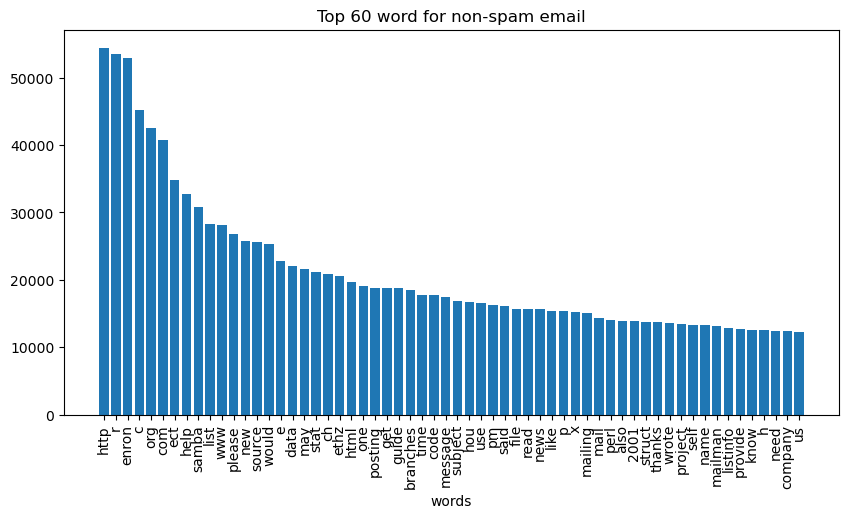

In [721]:
# Visualize the data
plt.figure(figsize=(10,5))
plot_df = df0.merge(new_df, left_on='index', right_index=True)
plt.bar(plot_df[0], plot_df['count'])
plt.title('Top 60 word for non-spam email')
plt.xlabel('words')
plt.xticks(rotation=90)
plt.show()

The most common word that appear in non-spam email include (new, source, data, file, read ..)

In [723]:
df.shape

(83448, 2)

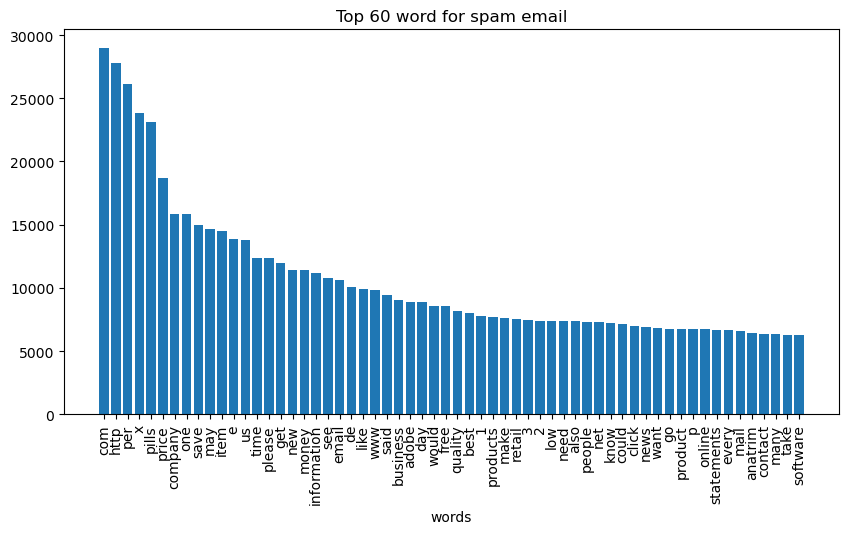

In [722]:
# Visualize the data
plt.figure(figsize=(10,5))
plot_df = df1.merge(new_df, left_on='index', right_index=True)
plt.bar(plot_df[0], plot_df['count'])
plt.title('Top 60 word for spam email')
plt.xlabel('words')
plt.xticks(rotation=90)
plt.show()

The most popular word for spam email include (price, company, save, money, information, ...)

In [399]:
# Splitting the data into train and test set
x_train, x_test, y_train, y_test = train_test_split(padded, y, shuffle=True, test_size=0.2,random_state=10, stratify=y)

# Random Forest

In [401]:
# Build and train random forest model
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [402]:
print(classification_report(y_test, rf.predict(x_test)))
print('score: ',rf.score(x_test, y_test))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      7908
           1       0.84      0.84      0.84      8782

    accuracy                           0.83     16690
   macro avg       0.83      0.83      0.83     16690
weighted avg       0.83      0.83      0.83     16690

score:  0.8289994008388256


The score is surprisingly good consider for a simple machine learning model, but let check the cross_val_score of it

In [403]:
np.mean(cross_val_score(rf, padded, y, cv=5))

0.8254242133994613

Same performance, let see if we can improve the performance with deep learning model !

# RNN

In [453]:
#Try RNN
RNN_model = Sequential([
    Embedding(input_dim=20000, output_dim=50, input_length=max_lenght),
    SimpleRNN(64, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    SimpleRNN(64, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [454]:
RNN_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 500, 50)           1000000   
                                                                 
 simple_rnn_37 (SimpleRNN)   (None, 500, 64)           7360      
                                                                 
 batch_normalization_11 (Bat  (None, 500, 64)          256       
 chNormalization)                                                
                                                                 
 dropout_48 (Dropout)        (None, 500, 64)           0         
                                                                 
 simple_rnn_38 (SimpleRNN)   (None, 64)                8256      
                                                                 
 batch_normalization_12 (Bat  (None, 64)               256       
 chNormalization)                                    

In [479]:
RNN_model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1044/1044 [==============================] - 219s 210ms/step - loss: nan - acc: 0.4738 - val_loss: nan - val_acc: 0.4738
Epoch 2/5
1044/1044 [==============================] - 220s 211ms/step - loss: nan - acc: 0.4738 - val_loss: nan - val_acc: 0.4738
Epoch 3/5
1044/1044 [==============================] - 225s 215ms/step - loss: nan - acc: 0.4738 - val_loss: nan - val_acc: 0.4738
Epoch 4/5
1044/1044 [==============================] - 228s 218ms/step - loss: nan - acc: 0.4738 - val_loss: nan - val_acc: 0.4738
Epoch 5/5
1044/1044 [==============================] - 231s 221ms/step - loss: nan - acc: 0.4738 - val_loss: nan - val_acc: 0.4738


We can see that the RNN model struggle to learn this data base on the accuracy and loss

# GRU

In [451]:
#Try GRU

GRU_model = Sequential([
    Embedding(input_dim=20000, output_dim=50, input_length=max_lenght),
    GRU(64, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    GRU(64, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
GRU_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [452]:
GRU_model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1044/1044 [==============================] - 362s 344ms/step - loss: 0.6742 - acc: 0.5476 - val_loss: 0.6832 - val_acc: 0.5461
Epoch 2/10
1044/1044 [==============================] - 352s 337ms/step - loss: 0.5573 - acc: 0.6380 - val_loss: 0.0907 - val_acc: 0.9736
Epoch 3/10
1044/1044 [==============================] - 364s 348ms/step - loss: 0.0520 - acc: 0.9844 - val_loss: 0.0494 - val_acc: 0.9827
Epoch 4/10
1044/1044 [==============================] - 358s 343ms/step - loss: 0.0201 - acc: 0.9945 - val_loss: 0.0391 - val_acc: 0.9883
Epoch 5/10
1044/1044 [==============================] - 354s 339ms/step - loss: 0.0128 - acc: 0.9963 - val_loss: 0.0623 - val_acc: 0.9843
Epoch 6/10
1044/1044 [==============================] - 351s 336ms/step - loss: 0.0096 - acc: 0.9974 - val_loss: 0.0373 - val_acc: 0.9879
Epoch 7/10
1044/1044 [==============================] - 350s 335ms/step - loss: 0.0058 - acc: 0.9985 - val_loss: 0.0555 - val_acc: 0.9877
Epoch 8/10
1044/1044 [============

In [478]:
pred = (GRU_model.predict(x_test)>0.5).astype(int)
print(classification_report(y_test, pred))

522/522 [==============================] - 45s 86ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7908
           1       0.99      0.99      0.99      8782

    accuracy                           0.99     16690
   macro avg       0.99      0.99      0.99     16690
weighted avg       0.99      0.99      0.99     16690



The model perform exceedingly well with just 10 epoch all the score such as precision, recall, f1-score are around 0.98 to 0.99

**After testing out 3 model from the most simple to the advanced one I have reach the conclusion:**
   - The RandomForest model work well unexpectedly with accuracy arround 0.84
   - The second model which is RNN although more advanced than RandomForest, struggle to learn the pattern of the data
   - Lastly, the advanced model which is GRU perform with almost perfect score (all the metric score around 0.98 to 0.99)

**Although the performance overall is good it is the best to introduce more data to the model to make sure it adapt well to unseen data, structure for the most optimized email classification**

# Thank you for checking my project